In [1]:
import os
from scipy import ndimage, misc
from matplotlib import pyplot as plt
import numpy as np
import imageio
from sklearn.datasets import load_boston, load_digits, load_iris, load_wine
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import cv2
from sklearn.svm import SVR
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()  # for plot styling
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [2]:
df = pd.read_excel('Dummy dataset.xlsx')

As we see, There are some null rows have to be handled first.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38685 entries, 0 to 38684
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Total O/S         38685 non-null  float64       
 1   TENOR_@Booking    38685 non-null  int64         
 2   Loan Term         38685 non-null  object        
 3   BOOKING_DATE      38685 non-null  datetime64[ns]
 4   MATURITY_DATE     38685 non-null  datetime64[ns]
 5    DPD              38685 non-null  int64         
 6   DOB               38601 non-null  datetime64[ns]
 7   AGE               38601 non-null  float64       
 8   AGE at Maturity   38601 non-null  datetime64[ns]
 9   GENDER            38677 non-null  object        
 10  Customer Segment  38666 non-null  object        
dtypes: datetime64[ns](4), float64(2), int64(2), object(3)
memory usage: 3.2+ MB


In [4]:
df.drop("DOB", axis=1, inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38685 entries, 0 to 38684
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Total O/S         38685 non-null  float64       
 1   TENOR_@Booking    38685 non-null  int64         
 2   Loan Term         38685 non-null  object        
 3   BOOKING_DATE      38685 non-null  datetime64[ns]
 4   MATURITY_DATE     38685 non-null  datetime64[ns]
 5    DPD              38685 non-null  int64         
 6   AGE               38601 non-null  float64       
 7   AGE at Maturity   38601 non-null  datetime64[ns]
 8   GENDER            38677 non-null  object        
 9   Customer Segment  38666 non-null  object        
dtypes: datetime64[ns](3), float64(2), int64(2), object(3)
memory usage: 3.0+ MB


In [6]:
df.head()

,Total O/S,TENOR_@Booking,Loan Term,BOOKING_DATE,MATURITY_DATE,DPD,AGE,AGE at Maturity,GENDER,Customer Segment
0,178630.00,120,10 Years,2019-07-31,2029-04-03,0,38.469863,1948-04-04,MALE,Salaried
1,376444.57,120,10 Years,2019-03-04,2028-07-03,0,58.212329,1967-12-27,MALE,Salaried
2,253984.28,84,7 Years,2019-05-05,2025-07-03,0,56.806849,1963-08-01,MALE,Salaried
3,779620.11,108,9 Years,2021-04-26,2030-04-25,5,38.028767,1946-10-26,MALE,Self Employed & Professional
4,103377.43,60,5 Years,2021-04-27,2026-04-25,0,40.343836,1945-02-17,MALE,Salaried


In [7]:
segments = {'Salaried': 0, 'Self Employed & Professional':1}
df = df.replace({"Customer Segment": segments})

gends = {'MALE': 0, 'Male': 0, 'Female': 1,'FEMALE': 1}
df = df.replace({"GENDER": gends})

years = {'10 Years': 10, '7 Years': 7 , '9 Years': 9, '8 Years': 8 , '6 Years': 6 , '5 Years': 5 , '4 Years': 4 ,
         '3 Years': 3 , '2 Years': 2 , '1 Year': 1 , 'More than 10 Years': 11 }
df = df.replace({"Loan Term": years})


df.dropna()
df.drop("AGE at Maturity", axis=1, inplace = True)
df.drop("MATURITY_DATE", axis=1, inplace = True)


In [8]:
import datetime
current_time = datetime.datetime.now()
ago = current_time - df['BOOKING_DATE']
df['ago'] = ago
df["ago"].apply(lambda x: x/np.timedelta64(1, 'Y')).fillna(0).astype('int64')

0        2
1        2
2        2
3        0
4        0
        ..
38680    8
38681    7
38682    8
38683    6
38684    9
Name: ago, Length: 38685, dtype: int64

In [9]:
df.drop("BOOKING_DATE", axis=1, inplace = True)

In [10]:
df['ago'] = df["ago"].apply(lambda x: x/np.timedelta64(1, 'Y')).fillna(0).astype('int64')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38685 entries, 0 to 38684
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Total O/S         38685 non-null  float64
 1   TENOR_@Booking    38685 non-null  int64  
 2   Loan Term         38685 non-null  int64  
 3    DPD              38685 non-null  int64  
 4   AGE               38601 non-null  float64
 5   GENDER            38677 non-null  float64
 6   Customer Segment  38666 non-null  float64
 7   ago               38685 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 2.4 MB


FV=PV×(1+i)^n
 
where:
FV=Future value
PV=Present value (original amount of money)
i=Interest rate per period
n=Number of periods

In [12]:
i = 0.45
df['Total O/S'] = df['Total O/S']*(1+i)**df['ago']

In [13]:
df.duplicated().sum()

836

In [14]:
df.drop_duplicates(subset = None, keep = "first", inplace = True)

In [15]:
df.duplicated().sum()

0

In [16]:
df.isnull().sum()

Total O/S            0
TENOR_@Booking       0
Loan Term            0
 DPD                 0
AGE                 65
GENDER               7
Customer Segment    19
ago                  0
dtype: int64

In [17]:
df = df.dropna(axis=0, how='any')

In [18]:
df.isnull().sum()

Total O/S           0
TENOR_@Booking      0
Loan Term           0
 DPD                0
AGE                 0
GENDER              0
Customer Segment    0
ago                 0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37761 entries, 0 to 38684
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Total O/S         37761 non-null  float64
 1   TENOR_@Booking    37761 non-null  int64  
 2   Loan Term         37761 non-null  int64  
 3    DPD              37761 non-null  int64  
 4   AGE               37761 non-null  float64
 5   GENDER            37761 non-null  float64
 6   Customer Segment  37761 non-null  float64
 7   ago               37761 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 2.6 MB


In [20]:
X = df.to_numpy()

In [21]:
X

array([[3.75569575e+05, 1.20000000e+02, 1.00000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       [7.91474708e+05, 1.20000000e+02, 1.00000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       [5.34001949e+05, 8.40000000e+01, 7.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.00635509e+02, 1.08000000e+02, 9.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 8.00000000e+00],
       [2.03541105e+01, 9.60000000e+01, 8.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.00000000e+00],
       [2.09673594e+01, 1.08000000e+02, 9.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.00000000e+00]])

In [22]:
sse = []
Krange =  range(1,20)
for i in Krange:
  kmeans = KMeans(n_clusters=3, random_state=0)
  y_prdeicted = kmeans.fit_predict(X)
  sse.append(kmeans.inertia_)

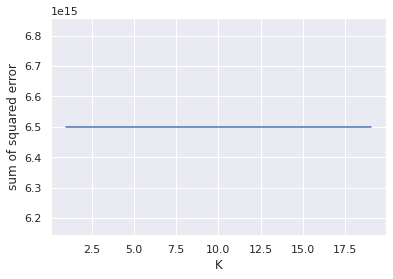

In [23]:
plt.xlabel("K")
plt.ylabel("sum of squared error")
plt.plot(Krange,sse)

In [46]:
df['cluster'] = y_prdeicted

2

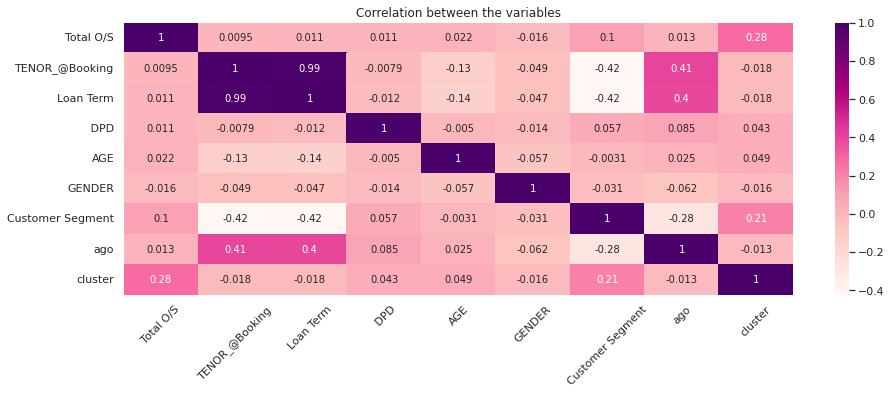

In [25]:
fig, ax = plt.subplots(figsize=(15,5))         # Sample figsize in inches
sns.heatmap(df.corr(), annot = True, ax=ax, cmap="RdPu");
plt.title('Correlation between the variables')
plt.xticks(rotation=45);

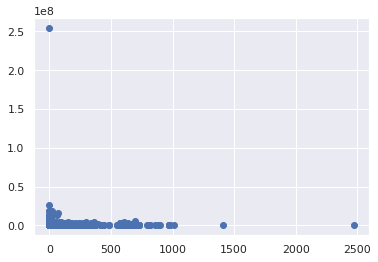

In [26]:
plt.scatter(df[' DPD'],df['Total O/S'])

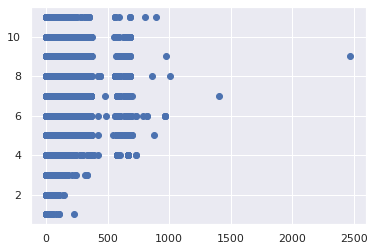

In [27]:
plt.scatter(df[' DPD'],df['Loan Term'])

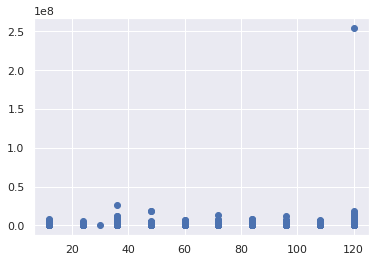

In [28]:
plt.scatter(df['TENOR_@Booking'],df['Total O/S'])

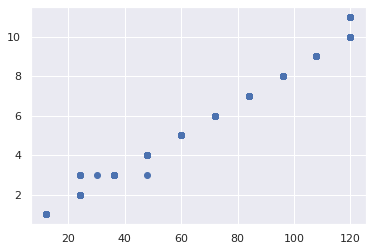

In [29]:
plt.scatter(df['TENOR_@Booking'],df['Loan Term'])

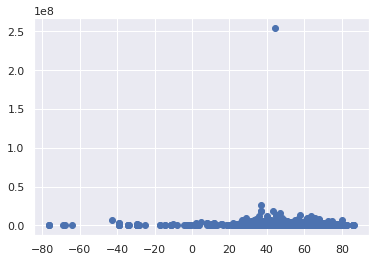

In [30]:
plt.scatter(df['AGE'],df['Total O/S'])

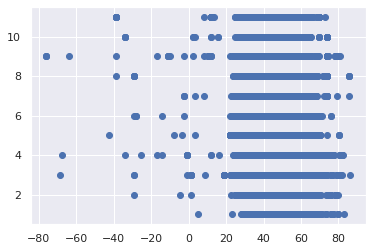

In [31]:
plt.scatter(df['AGE'],df['Loan Term'])

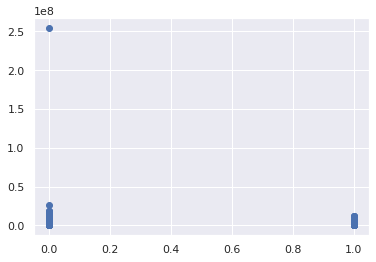

In [32]:
plt.scatter(df['GENDER'],df['Total O/S'])

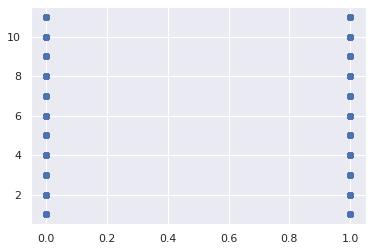

In [33]:
plt.scatter(df['GENDER'],df['Loan Term'])

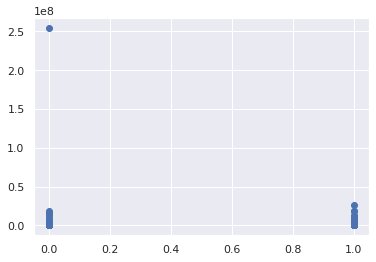

In [34]:
plt.scatter(df['Customer Segment'],df['Total O/S'])

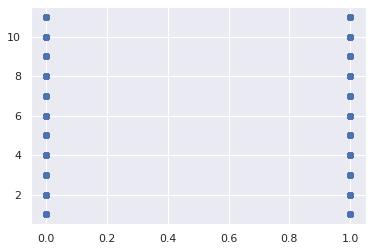

In [35]:
plt.scatter(df['Customer Segment'],df['Loan Term'])

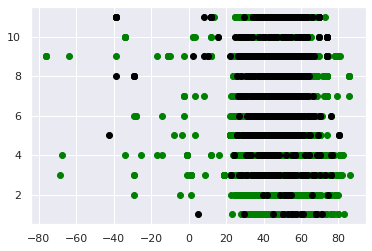

In [36]:
df0 = df[df.cluster == 0]
df1 = df[df.cluster == 1]
df2 = df[df.cluster == 2]

plt.scatter(df0['AGE'],df0['Loan Term'], color = 'green')
plt.scatter(df1['AGE'],df1['Loan Term'], color = 'blue')
plt.scatter(df2['AGE'],df2['Loan Term'], color = 'black')

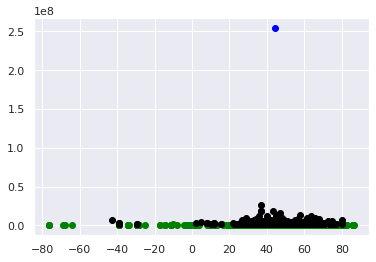

In [37]:
plt.scatter(df0['AGE'],df0['Total O/S'], color = "green")
plt.scatter(df1['AGE'],df1['Total O/S'], color = 'blue')
plt.scatter(df2['AGE'],df2['Total O/S'], color = 'black')

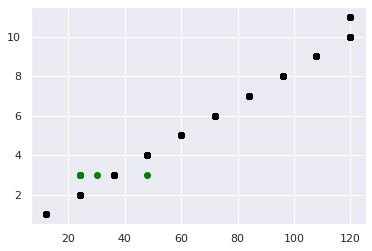

In [38]:
plt.scatter(df0['TENOR_@Booking'],df0['Loan Term'], color = "green")
plt.scatter(df1['TENOR_@Booking'],df1['Loan Term'],color =  'blue')
plt.scatter(df2['TENOR_@Booking'],df2['Loan Term'], color = "black")

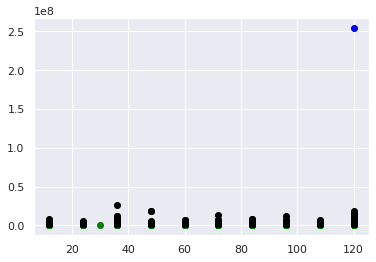

In [39]:
plt.scatter(df0['TENOR_@Booking'],df0['Total O/S'], color = "green")
plt.scatter(df1['TENOR_@Booking'],df1['Total O/S'], color = 'blue')
plt.scatter(df2['TENOR_@Booking'],df2['Total O/S'], color = "black")

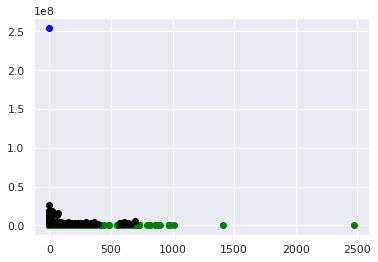

In [40]:
plt.scatter(df0[' DPD'],df0['Total O/S'], color = "green")
plt.scatter(df1[' DPD'],df1['Total O/S'], color = 'blue')
plt.scatter(df2[' DPD'],df2['Total O/S'], color = "black")

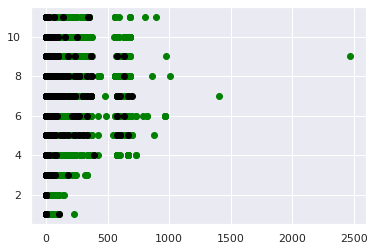

In [41]:
plt.scatter(df0[' DPD'],df0['Loan Term'], color = "green")
plt.scatter(df1[' DPD'],df1['Loan Term'], color = 'blue')
plt.scatter(df2[' DPD'],df2['Loan Term'], color = "black")

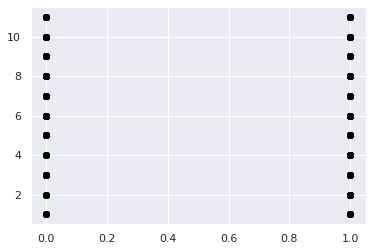

In [42]:
plt.scatter(df0['Customer Segment'],df0['Loan Term'], color = "green")
plt.scatter(df1['Customer Segment'],df1['Loan Term'], color = 'blue')
plt.scatter(df2['Customer Segment'],df2['Loan Term'], color = "black")

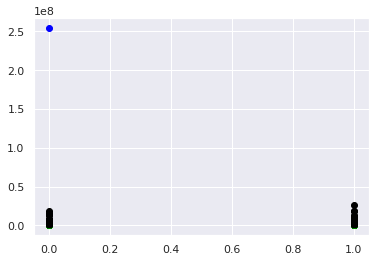

In [43]:
plt.scatter(df0['Customer Segment'],df0['Total O/S'], color = "green")
plt.scatter(df1['Customer Segment'],df1['Total O/S'], color = 'blue')
plt.scatter(df2['Customer Segment'],df2['Total O/S'], color = "black")

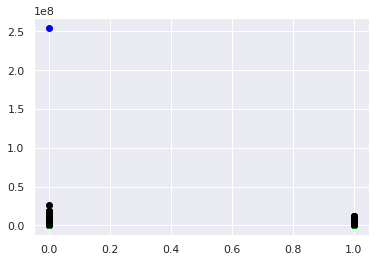

In [44]:
plt.scatter(df0['GENDER'],df0['Total O/S'], color = "green")
plt.scatter(df1['GENDER'],df1['Total O/S'], color = 'blue')
plt.scatter(df2['GENDER'],df2['Total O/S'], color = "black")

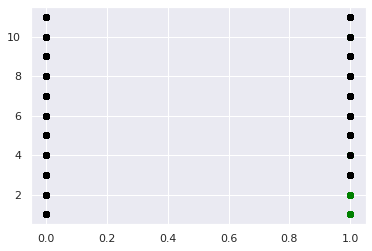

In [45]:
plt.scatter(df0['GENDER'],df0['Loan Term'], color = "green")
plt.scatter(df1['GENDER'],df1['Loan Term'], color = 'blue')
plt.scatter(df2['GENDER'],df2['Loan Term'], color = "black")